Forest (all types)
 - kmeans - separate xu and liu, harmonized in it's own cluster
 - OPTICS - nothing separated
 
Grasslands
 - kmeans - xu and liu in it's own cluster
 - OPTICS - nothing separated

In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from utils import *

In [2]:
# Load the dataset
biomass_data_AZ = pd.read_csv('agb_AZ_final.csv')
biomass_data_CA = pd.read_csv('agb_CA.csv')

biomass_data=biomass_data_AZ.append(biomass_data_CA, ignore_index=True)
biomass_data

#Drop the year column
biomass_data = biomass_data.drop('year', axis=1)

In [ ]:
biomass_data_CA

In [ ]:
biomass_data_AZ

In [ ]:
biomass_data

In [3]:
df=biomass_data

# Get unique product categories
unique_products = df['product'].unique()

# Create a dictionary to store separate dataframes
product_dfs = {}

# Separate the dataframe for each unique product
for product in unique_products:
    product_dfs[product] = df[df['product'] == product].copy()
    
    # Reset index for each separated dataframe
    product_dfs[product].reset_index(drop=True, inplace=True)

In [4]:
#Combine agb data for all products into one dataframe, locations on rows, products on cols

# Create an empty dataframe to store the combined 'agb_MG_ha' columns
combined_df = pd.DataFrame()

# Append 'agb_MG_ha' column for each product category into the combined dataframe
for product in unique_products:
    # Extract the 'agb_MG_ha' column for the current product category
    product_agb = product_dfs[product]['agb_Mg_ha'].reset_index(drop=True)
    
    # Rename the column to indicate the product category
    product_agb.name = f'{product}'
    
    # Append the column to the combined dataframe
    combined_df = pd.concat([combined_df, product_agb], axis=1)

In [5]:
# Prep data for clustering

# Remove non-numeric rows
data_transposed_numeric = combined_df.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop rows with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(how='all')

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
# Impute missing values with ROW mean (must use transposed df and axis=1 for rows)
data_imputed = data_transposed_numeric.T.fillna(data_transposed_numeric.mean(axis=1)).T

In [6]:
data_imputed

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000
1,-9999.000000,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.500000,-7498.500000
2,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
3,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000
4,0.000000,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.000000,7.759220
...,...,...,...,...,...,...,...,...,...,...
10791,302.545441,293.200012,296.273346,431.000000,987.000000,233.294724,554.041753,302.653900,1798.470093,341.938263
10792,0.000000,6.000000,15.617992,18.459537,39.000000,10.028250,18.459537,1.476027,0.000000,75.554024
10794,-908.727295,0.000000,1.624960,-110.137969,7.000000,9.612687,-110.137969,0.906262,0.000000,8.479631
10798,0.000000,0.000000,3.049171,2.522635,4.000000,8.420034,2.522635,0.000000,0.000000,4.711873


In [7]:
#add back information columns. this df IS NOT used for clustering, just for reference
full_df=pd.concat([data_imputed,product_dfs['chopping']['Latitude']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['Longitude']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Name']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['IGBP_Class']], axis=1)
full_df=pd.concat([full_df,product_dfs['chopping']['ffp_radius']], axis=1)
full_df=full_df.dropna(how='any')
full_df

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu,Latitude,Longitude,IGBP_Name,IGBP_Class,ffp_radius
0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,36.228055,-118.502698,Evergreen Needleleaf Forest,1,1
1,-9999.000000,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.500000,-7498.500000,35.283820,-115.103417,Evergreen Needleleaf Forest,1,1
2,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,36.335968,-117.900180,Evergreen Needleleaf Forest,1,1
3,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,33.620168,-108.709532,Evergreen Needleleaf Forest,1,1
4,0.000000,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.000000,7.759220,32.127377,-112.648381,Evergreen Needleleaf Forest,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10723,262.363648,307.399963,272.914520,479.000000,849.000000,204.049622,466.804103,222.100479,1369.890381,234.518311,40.058952,-123.988309,Barren or Sparsely Vegetated,16,1
10725,200.454544,218.998505,101.986191,494.000000,634.000000,58.441700,361.365587,154.295395,1182.690063,207.423889,38.341344,-119.860612,Barren or Sparsely Vegetated,16,1
10726,0.000000,0.000000,1.420700,8.554547,4.000000,10.353020,8.554547,7.216471,0.000000,45.446182,37.010422,-118.196942,Barren or Sparsely Vegetated,16,1
10730,0.000000,4.400000,12.668170,1.000000,11.000000,13.693995,42.196254,116.694397,0.000000,220.309723,40.202836,-121.776079,Barren or Sparsely Vegetated,16,1


In [8]:
unique_ecosys = full_df['IGBP_Name'].unique()
ecosys_counts = full_df['IGBP_Name'].value_counts()
ecosys_counts

Grasslands                            1780
Open Shrublands                       1452
Savannas                               601
Woody Savannas                         514
Barren or Sparsely Vegetated           421
Evergreen Broadleaf Forest             301
Deciduous Broadleaf Forest             252
Croplands                              246
Evergreen Needleleaf Forest            146
Urban and Built-up                     132
Permanent Wetlands                     103
Closed Shrublands                       49
Snow and Ice                            38
Cropland/Natural Vegetation Mosaic      30
Deciduous Needleleaf Forest             29
Mixed Forests                           23
Name: IGBP_Name, dtype: int64

# FORESTS

In [9]:
all_forests=['Evergreen Broadleaf Forest','Deciduous Broadleaf Forest','Evergreen Needleleaf Forest','Deciduous Needleleaf Forest','Mixed Forests']
forest_df = full_df[full_df['IGBP_Name'].isin(all_forests)]
indices_to_keep = full_df[full_df['IGBP_Name'].isin(all_forests)].index

In [10]:
mask = data_imputed.index.isin(indices_to_keep)
# Filter rows to keep only those with indices in indices_to_keep
subset_df = data_imputed[mask]
subset_df

,chopping,esa,gedi,gfw,harmonized,liu,ltgnn,menlove,natl,xu
0,445.0,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.000000,445.0,445.000000
1,-9999.0,-9999.000000,-7498.500000,-7498.500000,3.000000,-7498.500000,-9999.000000,-7498.500000,-7498.5,-7498.500000
2,2.0,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.000000
3,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.0,-9999.000000
4,0.0,3.227728,6.378667,3.440284,3.440284,9.633644,0.523012,0.000000,0.0,7.759220
...,...,...,...,...,...,...,...,...,...,...
6030,0.0,1.000000,13.615918,8.172272,14.000001,24.051985,8.172272,10.628405,0.0,2.081865
6032,-909.0,156.800003,67.589958,2.000000,19.000000,14.511115,-72.122103,0.000000,0.0,0.000000
6036,0.0,0.600000,1.314955,13.131396,24.999998,12.714009,13.131396,0.000000,0.0,65.422203
6037,0.0,2.800000,1.385505,7.686821,40.000000,16.987183,7.686821,0.000000,0.0,0.321880


In [11]:
#remove any row that has a NaN value (if any one product is NaN at a location, we want to exclude it)
data_imputed_f=subset_df.dropna(how='any')
data_imputed_f

#transpose dataset for clustering
data_transposed_f = data_imputed_f.T
data_transposed_f

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed_f)

## Kmeans

In [12]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.2367
Calinski-Harabasz Index: 2.9740
Davies-Bouldin Index: 1.2656
---
n_clusters = 3
Silhouette Index: 0.1515
Calinski-Harabasz Index: 2.5791
Davies-Bouldin Index: 1.0238
---
n_clusters = 4
Silhouette Index: 0.1893
Calinski-Harabasz Index: 2.8132
Davies-Bouldin Index: 0.4924
---
n_clusters = 5
Silhouette Index: 0.1797
Calinski-Harabasz Index: 3.3655
Davies-Bouldin Index: 0.4552
---
n_clusters = 6
Silhouette Index: 0.1866
Calinski-Harabasz Index: 4.8242
Davies-Bouldin Index: 0.3916
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.2367
Calinski-Harabasz Index - Optimal n_clusters: 6, Best Calinski-Harabasz Index: 4.8242
Davies-Bouldin Index - Optimal n_clusters: 6, Best Davies-Bouldin Index: 0.3916


Cluster labels: [2 2 2 2 0 1 2 2 2 1]
Distances between cluster centers:
[[ 0.         33.65075074 30.46564493]
 [33.65075074  0.         29.59163468]
 [30.46564493 29.59163468  0.        ]]

Distances between data points and cluster centers:
Data point 0: [45.69008427 43.22276478 23.3944491 ]
Data point 1: [34.1281198  34.122567   12.64263604]
Data point 2: [33.00467352 28.99192639 16.49347048]
Data point 3: [27.4327201  24.10507931 10.03942033]
Data point 4: [ 0.         33.65075074 30.46564493]
Data point 5: [40.57304202 18.43911545 37.82426153]
Data point 6: [29.10818406 28.49048317 10.65401297]
Data point 7: [33.82185651 31.35067339 13.93061732]
Data point 8: [37.27724659 43.11405479 24.29717429]
Data point 9: [36.03576375 18.43911545 31.63316112]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 2 contains multiple products, plotting heatmap...
Cluster 1 contains multiple products, plotting heatmap...


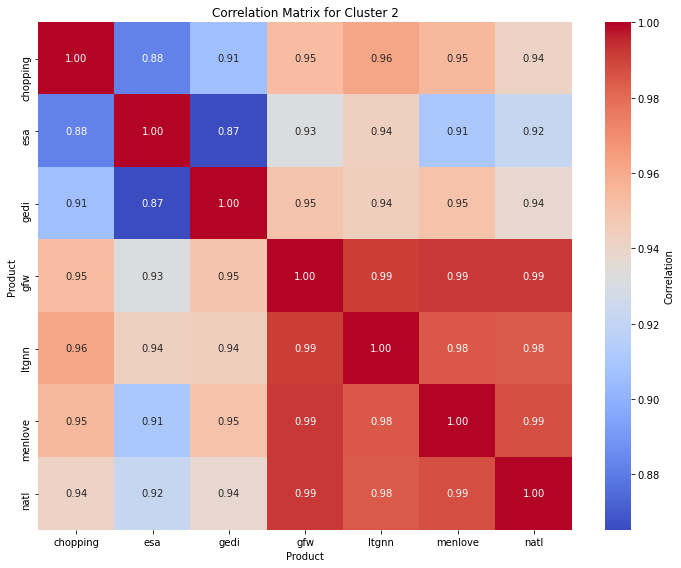

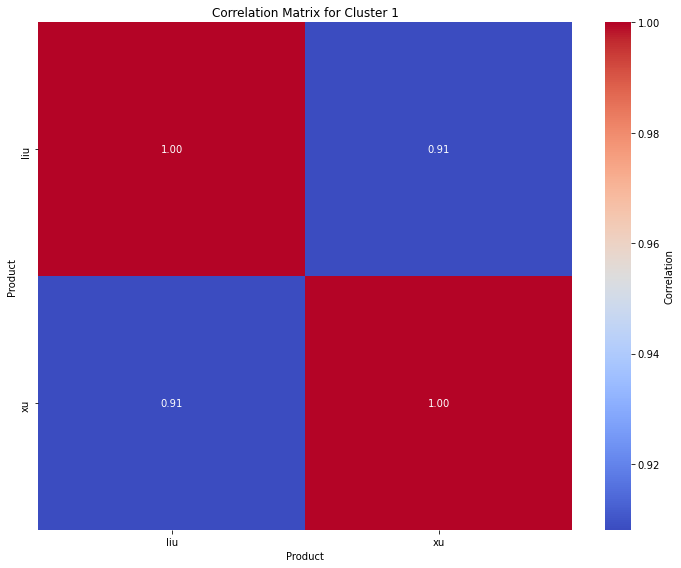

Silhouette Coefficient: 0.20024930453789938
Calinski-Harabasz Index: 2.7681400043835214
Davies-Bouldin Index: 0.9567624769770324


In [14]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_f.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_f.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

# OPTICS

OPTICS Cluster labels: [0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[0.]]

Distances between data points and cluster centers:
Data point 0: [27.48269652]
Data point 1: [15.84350716]
Data point 2: [16.03901429]
Data point 3: [7.1977726]
Data point 4: [25.80643417]
Data point 5: [31.99809802]
Data point 6: [10.78491232]
Data point 7: [15.38170298]
Data point 8: [26.71627042]
Data point 9: [26.23177873]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


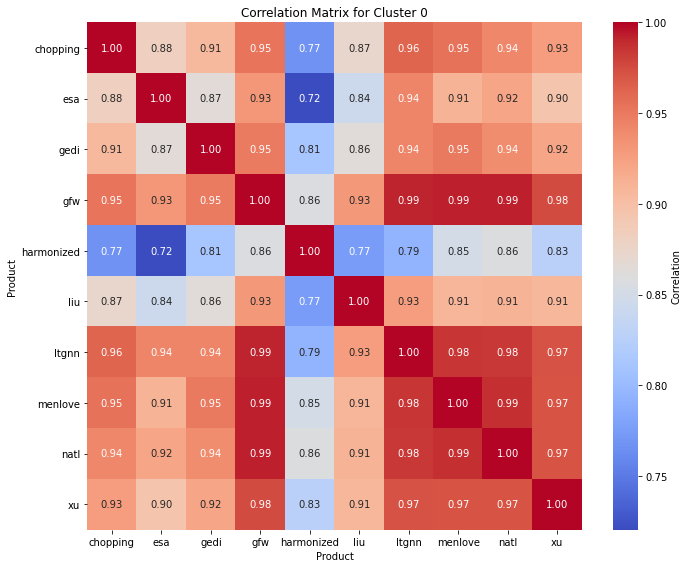

In [16]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_f.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_f.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
# print_indices(data_scaled, predicted_labels)

# GRASSLANDS AND OPEN SHRUBLANDS

In [26]:
gra_osh=['Grasslands']
grass_df = full_df[full_df['IGBP_Name'].isin(gra_osh)]
indices_to_keep = full_df[full_df['IGBP_Name'].isin(gra_osh)].index

mask_gra = data_imputed.index.isin(indices_to_keep)
# Filter rows to keep only those with indices in indices_to_keep
subset_df_gra = data_imputed[mask_gra]

#remove any row that has a NaN value (if any one product is NaN at a location, we want to exclude it)
data_imputed_gra=subset_df_gra.dropna(how='any')
data_imputed_gra

#transpose dataset for clustering
data_transposed_gra = data_imputed_gra.T
data_transposed_gra

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_transposed_gra)

In [27]:
# Initialize variables to store the best results for each index
best_n_silhouette = 0
best_silhouette = -1.0

best_n_calinski_harabasz = 0
best_calinski_harabasz = -1.0

best_n_davies_bouldin = 0
best_davies_bouldin = float('inf')

for n_clusters in range(2, 7):  # Start from 2 clusters
    print(f"n_clusters = {n_clusters}")
    
    # kmeans clustering
    cluster = KMeans(n_clusters=n_clusters)
    clusters = cluster.fit_predict(data_scaled)
    
    # Compute evaluation metrics
    silhouette = silhouette_score(data_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(data_scaled, clusters)
    davies_bouldin = davies_bouldin_score(data_scaled, clusters)
    
    print(f"Silhouette Index: {silhouette:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    
    # Update the best results for Silhouette Index
    if silhouette > best_silhouette:
        best_n_silhouette = n_clusters
        best_silhouette = silhouette
    
    # Update the best results for Calinski-Harabasz Index
    if calinski_harabasz > best_calinski_harabasz:
        best_n_calinski_harabasz = n_clusters
        best_calinski_harabasz = calinski_harabasz
    
    # Update the best results for Davies-Bouldin Index
    if davies_bouldin < best_davies_bouldin:
        best_n_davies_bouldin = n_clusters
        best_davies_bouldin = davies_bouldin
    
    print("---")

print("Best results for each index:")
print(f"Silhouette Index - Optimal n_clusters: {best_n_silhouette}, Best Silhouette Index: {best_silhouette:.4f}")
print(f"Calinski-Harabasz Index - Optimal n_clusters: {best_n_calinski_harabasz}, Best Calinski-Harabasz Index: {best_calinski_harabasz:.4f}")
print(f"Davies-Bouldin Index - Optimal n_clusters: {best_n_davies_bouldin}, Best Davies-Bouldin Index: {best_davies_bouldin:.4f}")

n_clusters = 2
Silhouette Index: 0.2723
Calinski-Harabasz Index: 3.4638
Davies-Bouldin Index: 1.2081
---
n_clusters = 3
Silhouette Index: 0.2073
Calinski-Harabasz Index: 2.9779
Davies-Bouldin Index: 0.5053
---
n_clusters = 4
Silhouette Index: 0.1967
Calinski-Harabasz Index: 3.2381
Davies-Bouldin Index: 0.4745
---
n_clusters = 5
Silhouette Index: 0.1937
Calinski-Harabasz Index: 3.9556
Davies-Bouldin Index: 0.4315
---
n_clusters = 6
Silhouette Index: 0.1656
Calinski-Harabasz Index: 5.0629
Davies-Bouldin Index: 0.3971
---
Best results for each index:
Silhouette Index - Optimal n_clusters: 2, Best Silhouette Index: 0.2723
Calinski-Harabasz Index - Optimal n_clusters: 6, Best Calinski-Harabasz Index: 5.0629
Davies-Bouldin Index - Optimal n_clusters: 6, Best Davies-Bouldin Index: 0.3971


Cluster labels: [0 0 0 0 0 2 0 0 0 1]
Distances between cluster centers:
[[ 0.         47.54943213 61.71453992]
 [47.54943213  0.         59.77696988]
 [61.71453992 59.77696988  0.        ]]

Distances between data points and cluster centers:
Data point 0: [35.5052696  66.72126046 76.66702135]
Data point 1: [21.39713161 55.62051525 69.05636774]
Data point 2: [24.18954993 49.28680716 62.33528085]
Data point 3: [13.95482238 42.33217669 55.12356771]
Data point 4: [39.65451172 55.12726814 65.69344163]
Data point 5: [61.71453992 59.77696988  0.        ]
Data point 6: [14.61505518 47.52872037 61.36828255]
Data point 7: [21.89801058 52.32507365 65.65041038]
Data point 8: [36.91922577 66.42344362 81.44851587]
Data point 9: [47.54943213  0.         59.77696988]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


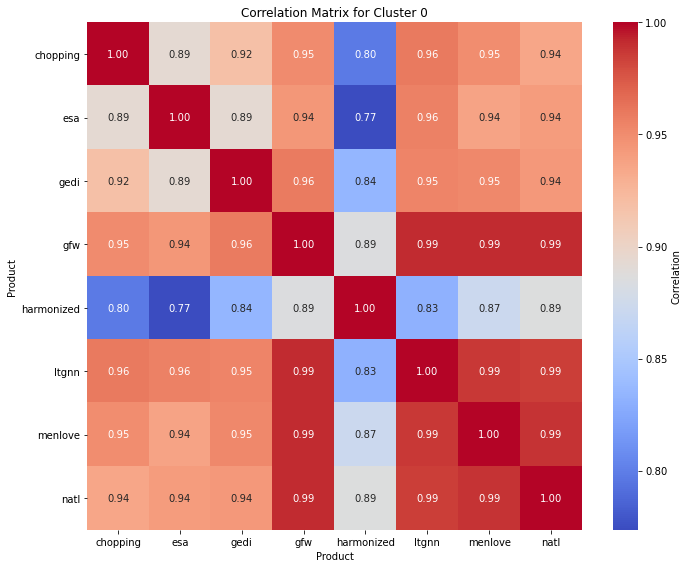

Silhouette Coefficient: 0.2073199268413637
Calinski-Harabasz Index: 2.9779217340999864
Davies-Bouldin Index: 0.5052887547948973


In [28]:
# kmeans clustering
km = KMeans(n_clusters=3)
clusters = km.fit_predict(data_scaled)
labels = km.labels_
print("Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_gra.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_gra.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']
corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)

## OPTICS

OPTICS Cluster labels: [0 0 0 0 0 0 0 0 0 0]
Distances between cluster centers:
[[0.]]

Distances between data points and cluster centers:
Data point 0: [38.98912304]
Data point 1: [25.12386637]
Data point 2: [24.04769479]
Data point 3: [10.84196699]
Data point 4: [38.36854363]
Data point 5: [53.69332051]
Data point 6: [15.87705611]
Data point 7: [23.81394066]
Data point 8: [40.9110419]
Data point 9: [40.55593561]
biomass_data_clustered has more columns than rows, clustering occured on products
Cluster 0 contains multiple products, plotting heatmap...


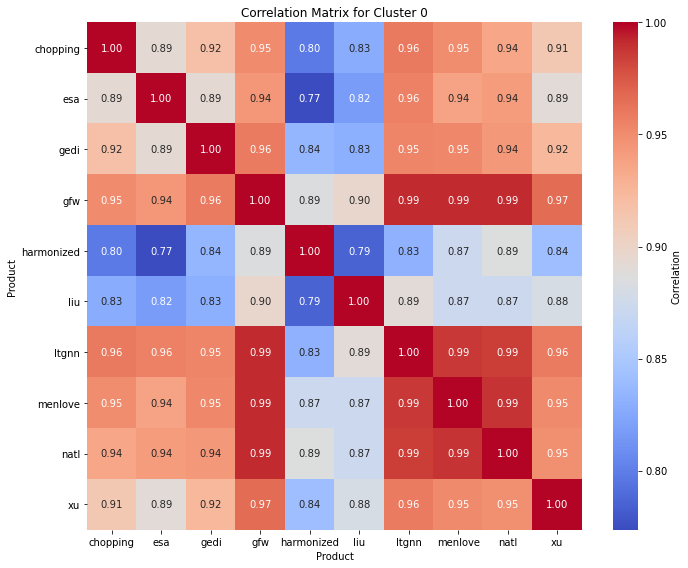

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [24]:
#OPTICS clustering
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(data_scaled)
labels = optics.labels_
print("OPTICS Cluster labels:", clusters)

cluster_distances=get_dist(data_scaled, labels)

# Add cluster labels to the transposed DataFrame
data_transposed_gra.loc[:,'cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_gra.reset_index()

# List of products
products = ['chopping', 'esa', 'gedi', 'gfw', 'harmonized', 'liu', 'ltgnn','menlove','natl','xu']

corr_matrix=plot_heat_by_clus(biomass_data_clustered,products)

# METRICS
# Extract predicted cluster labels
predicted_labels = biomass_data_clustered['cluster']
print_indices(data_scaled, predicted_labels)